In [1]:
from huggingface_hub import login
import os
from dotenv import load_dotenv

load_dotenv()
login(token = os.getenv('HF_KEY'))

os.chdir('..')
os.system('pwd')

/Users/adamswietek/Documents/PostDoc/HiddenHousing


0

In [153]:
"""
fetch available years of search location
"""
from geoai.download import pc_stac_search
from src.constants import BBOX

def fetch_pcstac_ids(bbox):
    items = pc_stac_search(
        collection="naip",
        bbox=bbox,
    )
    raw_file_names = [x.id.split('ca_')[1] for x in items]
    raw_file_years = [int(names.split('_')[5][:4]) for names in raw_file_names]
    raw_file_dict = dict(zip(raw_file_years,raw_file_names))

    return raw_file_dict 

pcstacIDs = fetch_pcstac_ids(BBOX['DEFAULT'])
print('Available Years', list(pcstacIDs))


Found 6 items matching search criteria
Available Years [2022, 2020, 2018, 2016, 2014, 2012]


In [ ]:
""" 
download naip tile at year
"""
from geoai.download import download_naip
from src.constants import BBOX
from pathlib import Path

bbox = BBOX['DEFAULT']
YR = [2014, 2022] #pcstacIDs.items()
OUTPUT_DIR = f"data/01_raw/naip"

# for yr, url in pcstacIDs.items():
NAIP_FP = {}
for yr in YR:#temp
    fp = download_naip(bbox = bbox,
                output_dir= OUTPUT_DIR,
                max_items=1,
                year=yr,
                overwrite=False
                )[0]
    NAIP_FP[yr] = Path(fp)
    


Found 1 NAIP items.
Skipping existing file: data/01_raw/naip/m_3411861_se_11_1_20140513.tif
Found 1 NAIP items.
Skipping existing file: data/01_raw/naip/m_3411861_se_11_060_20220511.tif


In [ ]:
"""
util defining geo references
"""
from src.constants import BBOX, WGS84_EPSG
from pathlib import Path

import geopandas as gpd
from shapely import box
import rioxarray

def fetch_reference(bbox_wgs84 = BBOX['DEFAULT']):
    ref_fp = Path("data/01_raw/naip/m_3411861_se_11_060_20220511.tif")
    ref = rioxarray.open_rasterio(ref_fp)#.rio.crs

    bbox_proj = (gpd.GeoSeries([box(*bbox_wgs84)], crs=WGS84_EPSG)
                .to_crs(ref.rio.crs)
                .total_bounds)
    
    return (ref, bbox_proj)

In [37]:
NAIP_FP[2014]

PosixPath('data/01_raw/naip/m_3411861_se_11_1_20140513.tif')

In [154]:
"""
load, align, & clip naip for each yr
"""
import rioxarray
from src.constants import BBOX

def read_align_clip(url,ref,bbox_proj):
    naip = rioxarray.open_rasterio(url)
    aligned = naip.rio.reproject_match(ref)
    clipped = aligned.rio.clip_box(*bbox_proj)
    return clipped

ref, bbox_proj = fetch_reference(BBOX['SMALL']) #update BBOX as needed
YR = [2014,2022]

naip = {}
for yr, url in NAIP_FP.items():
    naip[yr] = read_align_clip(url,ref, bbox_proj)



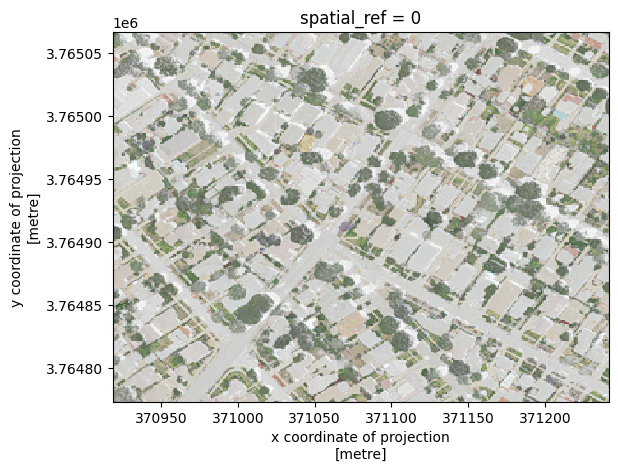

In [157]:
"""
visualize
"""
naip[2014].plot.imshow()

In [ ]:
#esri bfp detector
import geoai 

for yr, img in naip.items():
    #save to temp file
    in_fp = 'data/02_interm/temp.tif'
    img.rio.to_raster(in_fp, tiled=True, compress="LZW")

    out_fp = f'data/03_processed/esri/{url}'

    extractor = geoai.BuildingFootprintExtractor()
    
    mask_path = extractor.save_masks_as_geotiff(
        raster_path=in_fp,
        output_path=out_fp,
        confidence_threshold=0.5,
        mask_threshold=0.5,
    )




Model path not specified, downloading from Hugging Face...
Model downloaded to: /Users/adamswietek/.cache/huggingface/hub/models--giswqs--geoai/snapshots/089548329c81f128fa12576663e7abdedb5cfa0e/building_footprints_usa.pth
Model loaded successfully
Processing masks with parameters:
- Confidence threshold: 0.5
- Chip size: (512, 512)
- Mask threshold: 0.5
Dataset initialized with 1 rows and 2 columns of chips
Image dimensions: 539 x 489 pixels
Chip size: 512 x 512 pixels
Overlap: 25.0% (stride_x=384, stride_y=384)
CRS: EPSG:26911
Processing raster with 1 batches


  0%|          | 0/1 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████| 1/1 [00:06<00:00,  6.63s/it]

Resizing masks at image edges (set verbose=True for details)
Object masks saved to data/03_processed/esri/m_3411861_se_11_1_20140513.tif


Model path not specified, downloading from Hugging Face...
Model downloaded to: /Users/adamswietek/.cache/huggingface/hub/models--giswqs--geoai/snapshots/089548329c81f128fa12576663e7abdedb5cfa0e/building_footprints_usa.pth
Model loaded successfully
Processing masks with parameters:
- Confidence threshold: 0.5
- Chip size: (512, 512)
- Mask threshold: 0.5
Dataset initialized with 1 rows and 2 columns of chips
Image dimensions: 539 x 489 pixels
Chip size: 512 x 512 pixels
Overlap: 25.0% (stride_x=384, stride_y=384)
CRS: EPSG:26911
Processing raster with 1 batches


100%|██████████| 1/1 [00:05<00:00,  5.20s/it]

Resizing masks at image edges (set verbose=True for details)
Object masks saved to data/03_processed/esri/m_3411861_se_11_060_20220511.tif


In [ ]:
#meta sam3 detector
from samgeo import SamGeo3
from src.scale_detector import run_sam3_over_raster, stitch_save_sam3_masks

load_dotenv()
model_dir = Path(os.getenv('SAM3DIR'))
sam3 = SamGeo3(model_id=model_dir, backend='transformers')

PROMPT = "trees" #buildings
OUT_BASE = "data/03_processed/sam3/trees_"

for url, img in naip.items():
    in_fp = 'data/02_interm/temp.tif'
    img.rio.to_raster(in_fp, tiled=True, compress="LZW")

    sam3_results = run_sam3_over_raster(
        raster_path = in_fp,
        sam3 = sam3,
        prompt = PROMPT,
        chip_size = (256,256), 
        overlap = 0.2)

    out_fp = f'{OUT_BASE}{url}'

    stitch_save_sam3_masks(
        src_raster_path = in_fp, 
        mask_entries = sam3_results, 
        out_path = out_fp, 
        merge = 'or')


Using mps device and transformers backend


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !


In [86]:
trees = {}
esri = {}
sam3 = {}
for yr, url in NAIP_FP.items():
    mask_fp = Path(f'data/03_processed/sam3/trees_{url.name}')
    trees[yr] = rioxarray.open_rasterio(mask_fp)

    mask_fp = Path(f'data/03_processed/sam3/{url.name}')
    sam3[yr] = rioxarray.open_rasterio(mask_fp)

    mask_fp = Path(f'data/03_processed/esri/{url.name}')
    esri[yr] = rioxarray.open_rasterio(mask_fp)


In [168]:
'''plotting utils'''
import matplotlib.pyplot as plt
import numpy as np

def rx_clip_zeroes(z):
    z.values = np.where(z.values > 0,
                         z.values,
                         np.nan)
    return z

def plot_results(x, y1, y2):
    f, ax = plt.subplots(1,3,figsize = (20,5))

    x[y1].plot(cmap = 'Reds', ax = ax[0])
    x[y2].plot(cmap = 'Blues', ax = ax[1])

    xc = x[2022] - x[2014]
    xc = rx_clip_zeroes(xc)
    
    xc.plot(cmap = 'RdBu', ax= ax[2])
    ax[0].set_title(str(y1)), ax[1].set_title(str(y2)), ax[2].set_title('Change')

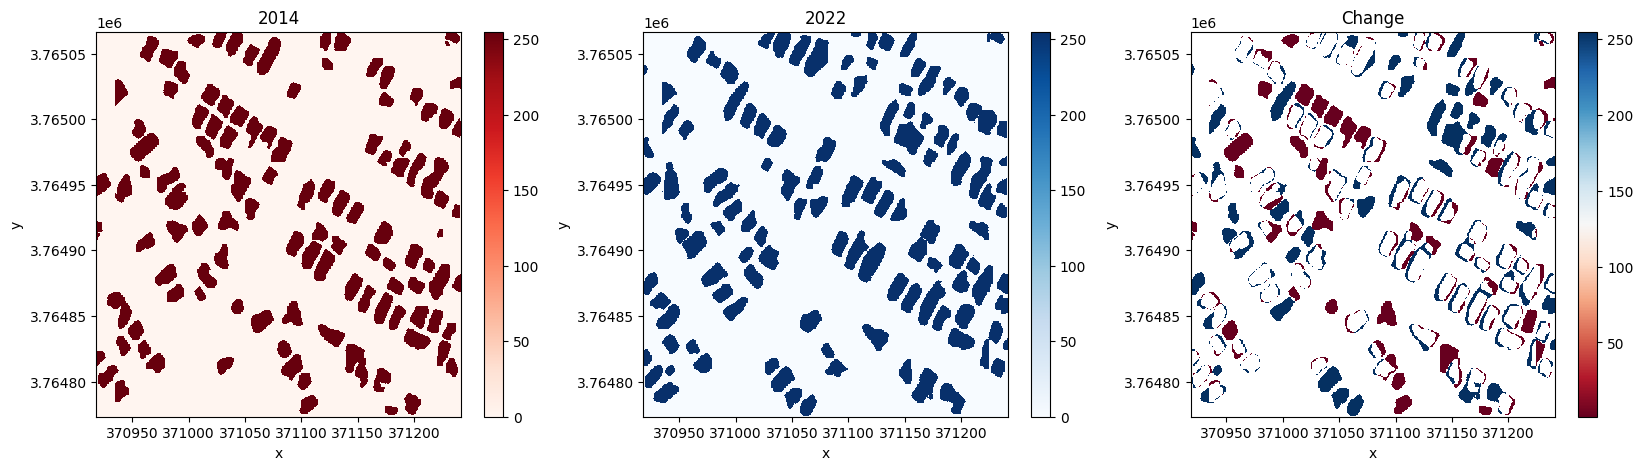

In [169]:
plot_results(esri, 2014, 2022)

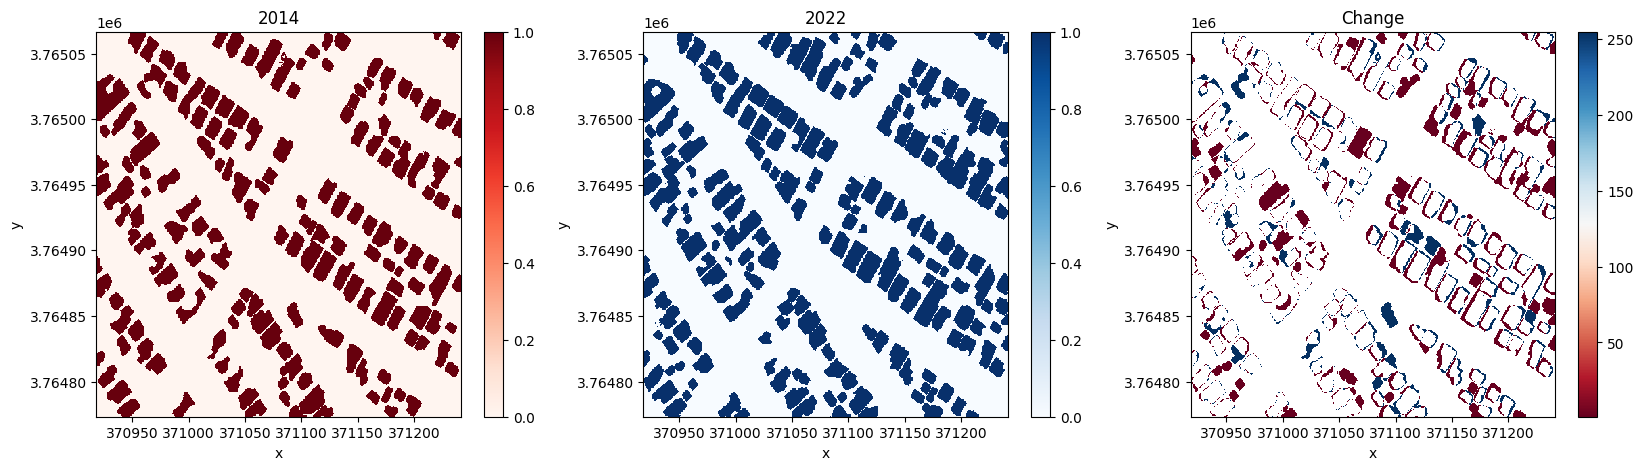

In [170]:
plot_results(sam3, 2014, 2022)

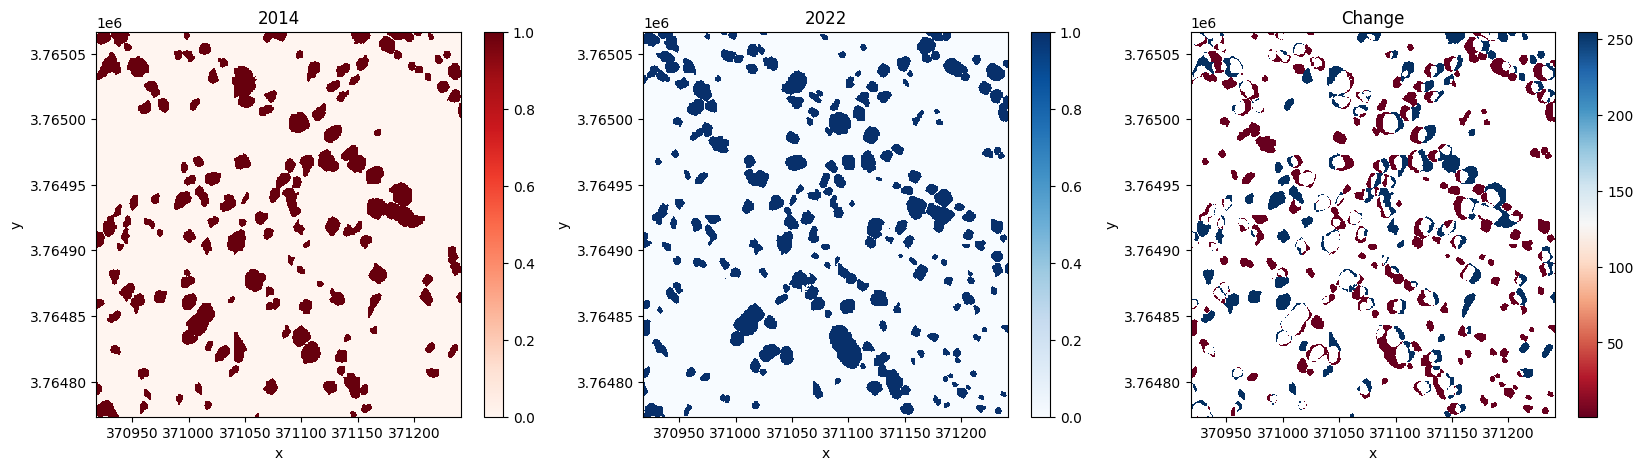

In [171]:
plot_results(trees, 2014, 2022)

In [ ]:
tree_change = (trees[2022] - trees[2014])

in_fp = 'data/04_results/tree_change_detection.tif'
tree_change.rio.to_raster(in_fp, tiled=True, compress="LZW")


In [39]:
in_fp = 'data/04_results/esri_change_detection.tif'
esri_change.rio.to_raster(in_fp, tiled=True, compress="LZW")

2025-12-13 22:00:38,205 - INFO - GDAL signalled an error: err_no=1, msg='PROJ: internal_proj_create_from_name: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.'


In [45]:
in_fp = 'data/04_results/sam3_change_detection.tif'
sam3_change.rio.to_raster(in_fp, tiled=True, compress="LZW")

2025-12-13 22:06:00,958 - INFO - GDAL signalled an error: err_no=1, msg='PROJ: internal_proj_create_from_name: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.'


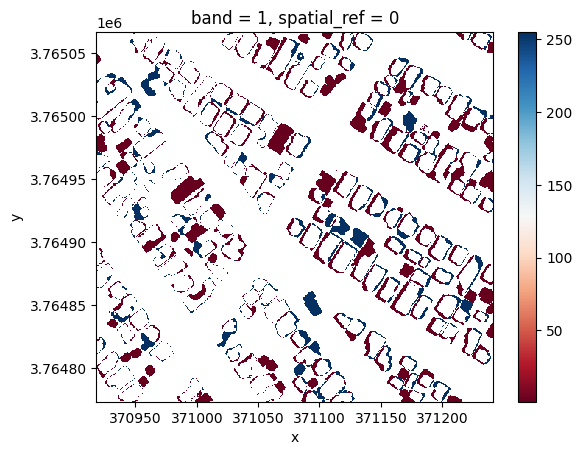

In [178]:
rx_clip_zeroes((sam3[2022]-sam3[2014])).plot(cmap = 'RdBu')